In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import numpy as np
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [2]:
# they don't show Ti metal and only one Graphite spectrum
ct_key = {
    'NAu-2_Med-S':'NAU2MEDS',
    'NAu-2_Hi-S':'NAU2HIGHS',
    'NAu-2_Low-S':'NAU2LOWS',
    'Picrite':'PICRITE',
    'Norite':'NORITE',
    'Shergottite':'SHERGOTTITE',
    'Kga-d_Med-S':'KGA2MEDS',
    'Macusanite':'MACUSANITE'
}

In [3]:
df = pd.read_csv('P:\\CHEMCAM_from_PDS\\LIBS_CCS_metadata_w_moc.csv')
df = df[df.Target.isin(ct_key.keys())].reset_index(drop=True)

C:\Users\ytsma22c\AppData\Local\Continuum\xraylarch\envs\auto\lib\site-packages\IPython\core\interactiveshell.py:3378: DtypeWarning: Columns (5,8,11,14,17,20,23,26,30) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df.Target.value_counts()

Shergottite    98
NAu-2_Hi-S     52
Norite         42
NAu-2_Low-S    41
NAu-2_Med-S    37
Picrite        25
Kga-d_Med-S    24
Macusanite      8
Name: Target, dtype: int64

Do loop with different time scales (max, min) as well as one that does all

In [5]:
print('min', df.sol.min(), 'max', df.sol.max())

min 13 max 3002


In [6]:
ranges = np.arange(df.sol.min(), df.sol.max()+100, 100)

# to get predicted values
comp_cols = [c.split(' ')[0] for c in df.columns if 'RMSEP' in c]
mean_cols = [c+'_mean' for c in comp_cols]
median_cols = [c+'_median' for c in comp_cols]
stdev_cols = [c+'_stdev' for c in comp_cols]

# to get RMSEPs
rmsep_cols = [c for c in df.columns if 'RMSEP' in c]
rmsep_mean = [c+'_mean' for c in rmsep_cols]
rmsep_median = [c+'_median' for c in rmsep_cols]
rmsep_stdev = [c+'_stdev' for c in rmsep_cols]

for l in [comp_cols,mean_cols,stdev_cols,median_cols,rmsep_cols,rmsep_mean,rmsep_median,rmsep_stdev]:
    l.insert(0,'Target')

In [7]:
range_names = []

count=0
for i in np.arange(len(ranges)-1):
    min = ranges[i]
    max = ranges[i+1]
    name = f'{min}-{max}'
    range_names.append(name)
    
    temp = df[(df.sol>=min)&(df.sol<max)].copy()
    # number of duplicates
    dup_temp = pd.DataFrame(temp.groupby('Target', as_index=False).size()).rename(columns={'size':'n_dups'})

    # average value
    mean_temp = temp[comp_cols].groupby('Target', as_index=False).mean()
    mean_temp.columns = mean_cols
    mean_rmsep_temp = temp[rmsep_cols].groupby('Target', as_index=False).mean()
    mean_rmsep_temp.columns = rmsep_mean

    # median value
    med_temp = temp[comp_cols].groupby('Target', as_index=False).median()
    med_temp.columns = median_cols
    med_rmsep_temp = temp[rmsep_cols].groupby('Target', as_index=False).median()
    med_rmsep_temp.columns = rmsep_median

    # stdev of values
    stdev_temp = temp[comp_cols].groupby('Target', as_index=False).std()
    stdev_temp.columns = stdev_cols
    std_rmsep_temp = temp[rmsep_cols].groupby('Target', as_index=False).std()
    std_rmsep_temp.columns = rmsep_stdev

    # merge results
    results_temp = dup_temp.merge(mean_temp).merge(med_temp).merge(stdev_temp).merge(mean_rmsep_temp).merge(med_rmsep_temp).merge(std_rmsep_temp)
    results_temp['range'] = name
    
    if count==0:
        all_results = results_temp.copy()
    else:
        all_results = pd.concat([all_results, results_temp], ignore_index=True)
    
    count+=1

In [8]:
# ADD AFTER GETTING ALL PREDS
all_results['PELLET NAME'] = all_results.Target.map(ct_key)
# actual
comps = pd.read_excel('Z:\\Millennium Set\\Millennium_COMPS_viewonly.xlsx')
comps.columns = list(comps.iloc[0])
comps = comps.drop(index=[0,1])

# format
new_comp_cols = comp_cols[1:].copy()
new_comp_cols.insert(0,'PELLET NAME')
new_comp_cols = ['FeO' if c == 'FeOT' else c for c in new_comp_cols]
comps = comps[new_comp_cols]

new_comp_cols = ['FeOT' if c == 'FeO' else c for c in new_comp_cols]
new_comp_cols = [c+'_actual' for c in comp_cols[1:]]
new_comp_cols.insert(0,'PELLET NAME')
comps.columns = new_comp_cols

# add actual values
all_results = all_results.merge(comps)
all_results.drop(columns='PELLET NAME', inplace=True)

# reorder
cols = list(all_results.columns[:2])
sort_cols = list(all_results.columns[2:])
sort_cols.sort()
cols.extend(sort_cols)
all_results = all_results[cols]

In [9]:
oxides = list(comp_cols[1:])

# actual RMSEP over time
time_results = []
for time in all_results.range.unique():
    
    temp = all_results[all_results.range==time].copy()
    
    for oxide in oxides:

        true = oxide+'_actual'
        pred = oxide+'_mean'

        # get data
        true = temp[true].values
        pred = temp[pred].values
        
        n_values = len(pred)

        rmse = sqrt(mean_squared_error(true, pred))
        if n_values <2:
            r2 = np.nan
        else:
            r2 = r2_score(true, pred)

        time_results.append([time,oxide,n_values,rmse,r2])
        
time_results = pd.DataFrame(time_results, columns=['range','oxide','n_samples','rmse','r2'])

# reported RMSEP over time
rmsep_mean.remove('Target')
rmsep_mean.insert(0,'range')
rmsep_stdev.remove('Target')
rmsep_stdev.insert(0,'range')

rmsep_mean_results = all_results[rmsep_mean].groupby('range', as_index=False).mean()
rmsep_std_results = all_results[rmsep_mean].groupby('range', as_index=False).std()
rmsep_std_results.columns = rmsep_stdev
rmsep_results_time = rmsep_mean_results.merge(rmsep_std_results)

time_rmsep_results = []

for time in rmsep_results_time.range.unique():
    
    temp = rmsep_results_time[rmsep_results_time.range==time].copy()
    
    for oxide in comp_cols[1:]:

        rmsep = oxide+' RMSEP_mean'
        std = oxide+' RMSEP_stdev'

        # get data
        rmsep = temp[rmsep].values[0]
        std = temp[std].values[0]

        time_rmsep_results.append([time,oxide,rmsep,std])
        
time_rmsep_results = pd.DataFrame(time_rmsep_results, columns=['range','oxide','reported_rmsep','reported_rmsep_stdev'])
empty_ranges = list(set(range_names) - set(time_results.range.unique()))
empty_range_df = pd.DataFrame({
    'range':[empty_ranges[0]]*len(oxides)+[empty_ranges[1]]*len(oxides),
    'oxide':oxides*2,
    'n_samples':0,
    'rmse':np.nan,
    'r2':np.nan,
    'reported_rmsep':np.nan,
    'reported_rmsep_stdev':np.nan,
    'range_min':np.nan,
    'range_max':np.nan
})

# combine
time_results = time_results.merge(time_rmsep_results)
time_results = pd.concat([time_results,empty_range_df])
time_results['range_min'] = [int(x.split('-')[0]) for x in time_results.range]
time_results['range_max'] = [int(x.split('-')[1]) for x in time_results.range]
time_results.sort_values('range_min', ignore_index=True, inplace=True)

In [10]:
time_results

,range,oxide,n_samples,rmse,r2,reported_rmsep,reported_rmsep_stdev,range_min,range_max
0,13-113,SiO2,6,5.814233,0.828655,5.245899,0.201069,13,113
1,13-113,TiO2,6,0.251704,0.673843,0.429757,0.070579,13,113
2,13-113,Al2O3,6,2.372202,0.880405,3.456772,0.239398,13,113
3,13-113,FeOT,6,3.308484,0.792205,3.020212,0.777228,13,113
4,13-113,MgO,6,1.103969,0.687318,1.663942,0.134904,13,113
...,...,...,...,...,...,...,...,...,...
265,2913-3013,CaO,5,2.279667,0.272826,3.170000,0.286356,2913,3013
266,2913-3013,MgO,5,0.791581,0.813269,1.670000,0.135093,2913,3013
267,2913-3013,Al2O3,5,1.754115,0.938911,3.400000,0.234521,2913,3013
268,2913-3013,SiO2,5,5.513607,0.213531,5.310000,0.185068,2913,3013


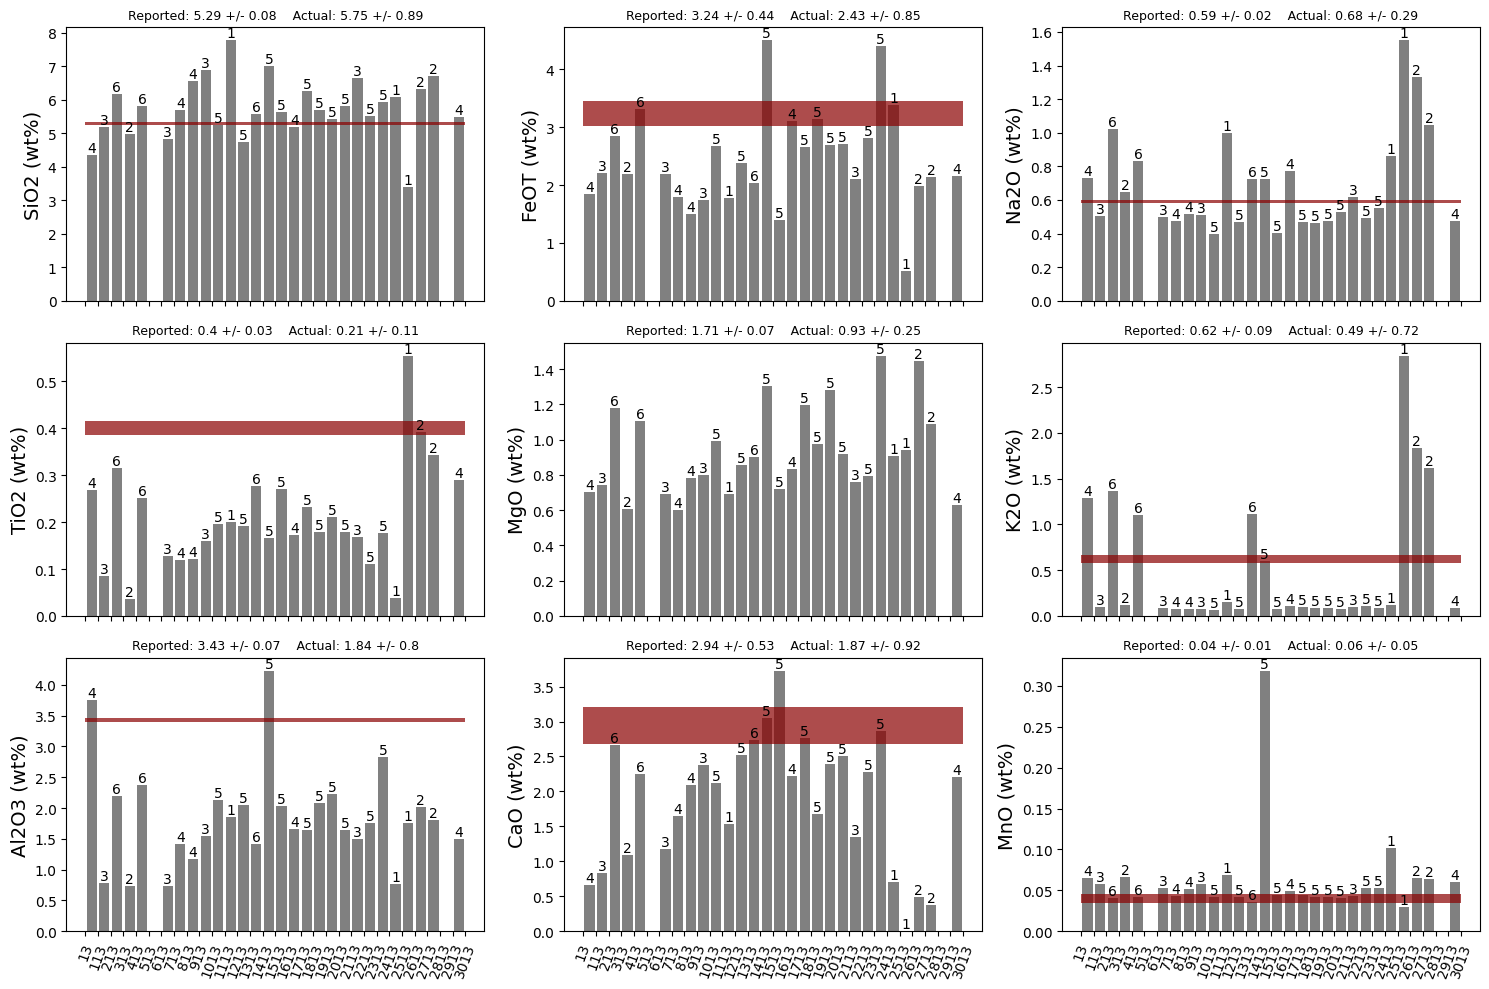

In [38]:
size = 10

x_labels = list(ranges)
x = np.arange(len(x_labels)-1)
x_ticks = xticks = [x-.5 for x in np.arange(len(x)+1)]

fig, ax = plt.subplots(nrows=3, 
                       ncols=3,
                       figsize = (15,10),
                       sharex=True)

x_ax = [0,1,2,0,1,2,0,1,2]
y_ax = [0,0,0,1,1,1,2,2,2]
i = 0
for oxide in oxides:
    
    # values
    temp = time_results[time_results['oxide']==oxide].copy().sort_values('range')
    avg_report = round(temp.reported_rmsep.mean(),2)
    avg_report_std = round(temp.reported_rmsep.std(),2)
    avg_rmse = round(temp.rmse.mean(),2)
    std_rmse = round(temp.rmse.std(),2)

    # reported RMSE box
    offset = avg_report_std/2
    origin = -.5
    y = avg_report - offset
    length = len(x)
    height = avg_report_std
    reported_errorbar = PatchCollection([Rectangle((origin, y), length, height)],
                                        edgecolor=None, facecolor='darkred', alpha=0.7)

    # actual error
    bar = ax[x_ax[i],y_ax[i]].bar(x, temp.rmse, color='grey', zorder=0)
#    if i==0:
    ax[x_ax[i],y_ax[i]].bar_label(bar, temp.n_samples)
    # reported error
    ax[x_ax[i],y_ax[i]].add_collection(reported_errorbar)
    ax[x_ax[i],y_ax[i]].set_title(f'Reported: {avg_report} +/- {avg_report_std}    Actual: {avg_rmse} +/- {std_rmse}',
                fontsize=size-1)
    ax[x_ax[i],y_ax[i]].set_ylabel(f'{oxide} (wt%)', fontsize=size+4)
    ax[x_ax[i],y_ax[i]].set_xticks(x_ticks)
    ax[x_ax[i],y_ax[i]].set_xticklabels(labels=x_labels, rotation=70)
    
    i+=1

#plt.annotate('Numbers above bars signify number of caltargets analysed during that time period',
#            (.1, .9), xycoords='figure fraction')
plt.tight_layout()
plt.savefig('rmsep_over_time_plot.jpg', dpi=600)
plt.show()